# Time Series Anomaly Detection with LSTM Autoencoders 

The following steps will be followed to detect anomalies in Johnson & Johnson stock price data using an LSTM autoencoder:

Train an LSTM autoencoder on the Johnson & Johnson’s stock price data from 1980 to 2021. We assume that there were no anomalies and they were normal.

Using the LSTM autoencoder to reconstruct the error on the test data.

If the reconstruction error for the test data is above the threshold, we label the data point as an anomaly.

In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
print(tf.__version__)

2.5.0


In [3]:
df = pd.read_csv('JNJ_1995-2021.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1995-01-03,13.656250,13.750000,13.437500,13.625000,7.373525,3628400
1,1995-01-04,13.500000,13.750000,13.500000,13.750000,7.441172,4161600
2,1995-01-05,13.718750,13.750000,13.625000,13.687500,7.407348,3164400
3,1995-01-06,13.625000,13.687500,13.562500,13.593750,7.356617,2118800
4,1995-01-09,13.531250,13.625000,13.406250,13.437500,7.272057,4505600
...,...,...,...,...,...,...,...
6634,2021-05-10,169.899994,171.529999,169.229996,170.270004,170.270004,8357500
6635,2021-05-11,170.649994,170.869995,168.279999,168.880005,168.880005,8217900
6636,2021-05-12,168.539993,169.800003,167.949997,168.199997,168.199997,6758300
6637,2021-05-13,166.970001,170.699997,166.970001,169.960007,169.960007,8018600


In [4]:
df = df[['Date', 'Close']]


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('1995-01-03 00:00:00'), Timestamp('2021-05-14 00:00:00'))

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,6639.0,73.103881,36.459676,13.4375,50.390625,62.91,99.834999,170.479996


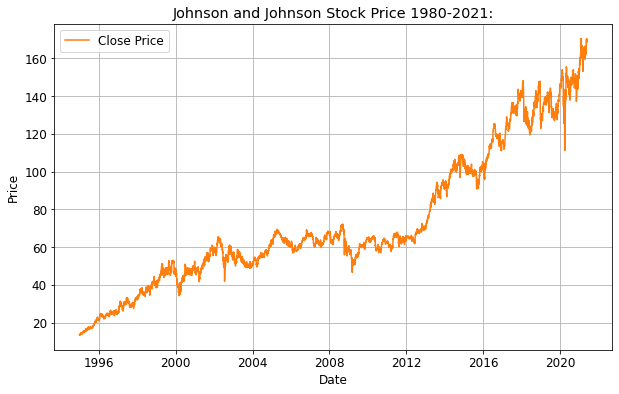

In [7]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(df.Date, df.Close, color='tab:orange', label='Close Price')

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Johnson and Johnson Stock Price 1980-2021:')
ax.grid(True)
ax.legend(loc='upper left')

In [8]:
#df = df.reset_index()['Close']

training_size=int(len(df)*0.85)
test_size=len(df)-training_size
train_data,test_data = df.loc[0:training_size], df.loc[training_size:len(df)]


In [9]:
train_data.shape, test_data.shape 

((5644, 2), (996, 2))

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(train_data[['Close']])

train_data['Close'] = scaler.transform(train_data[['Close']])
test_data['Close'] = scaler.transform(test_data[['Close']])

In [11]:
train_data.shape, test_data.shape 

((5644, 2), (996, 2))

In [12]:
TIME_STEPS=15

def create_dataset(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_data[['Close']], train_data['Close'])
X_test, y_test = create_dataset(test_data[['Close']], test_data['Close'])


In [13]:
X_train.shape, X_test.shape 

((5629, 15, 1), (981, 15, 1))

In [14]:
X_test.shape, y_test.shape

((981, 15, 1), (981,))

In [31]:
model = Sequential()
model.add(LSTM(265, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(265, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', optimizer=opt)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 265)               283020    
_________________________________________________________________
dropout_4 (Dropout)          (None, 265)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 15, 265)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 15, 265)           562860    
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 265)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 1)             266       
Total params: 846,146
Trainable params: 846,146
Non-trainable params: 0
________________________________________________

In [32]:
history = model.fit(X_train, y_train, 
                    epochs=5, 
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, mode='min')],
                    use_multiprocessing=True,
                    shuffle=False)

Epoch 1/5
159/159 [==============================] - 35s 177ms/step - loss: 0.1433 - val_loss: 0.1995
Epoch 2/5
159/159 [==============================] - 20s 125ms/step - loss: 0.0778 - val_loss: 0.1398
Epoch 3/5
159/159 [==============================] - 27s 172ms/step - loss: 0.0827 - val_loss: 0.1220
Epoch 4/5
159/159 [==============================] - 30s 187ms/step - loss: 0.0847 - val_loss: 0.1289
Epoch 5/5
159/159 [==============================] - 25s 155ms/step - loss: 0.0717 - val_loss: 0.0869


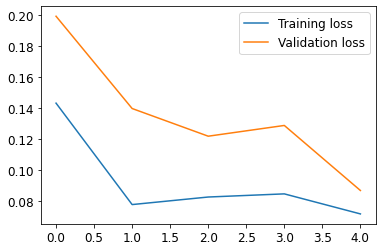

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [34]:
model.evaluate(X_test, y_test)

31/31 [==============================] - 1s 38ms/step - loss: 0.3063


0.3063430190086365

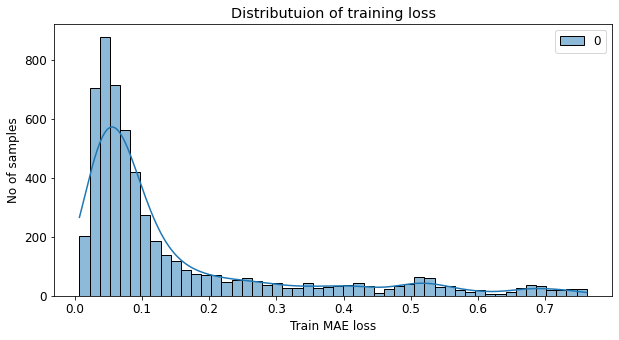

Reconstruction error threshold: 0.7619869615740215


In [35]:
import seaborn as sns 
train_pred = model.predict(X_train)
train_loss = (np.mean(np.abs(train_pred - X_train), axis=1))


plt.figure(figsize = (10,5))
sns.histplot(train_loss, bins=50, kde=True);
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.title('Distributuion of training loss')
plt.show()


threshold = np.max(train_loss)
print(f'Reconstruction error threshold: {threshold}')

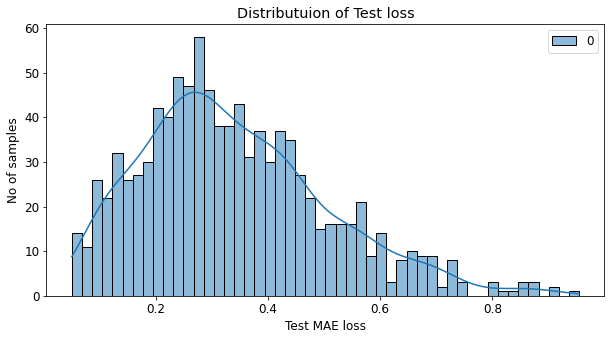

In [36]:
test_pred = model.predict(X_test, verbose=0)
test_loss = np.mean(np.abs(test_pred - X_test), axis=1)

plt.figure(figsize = (10,5))
sns.histplot(test_loss, bins=50, kde=True);
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.title('Distributuion of Test loss')
plt.show()



In [37]:
test_score_df = pd.DataFrame(test_data[TIME_STEPS:])
test_score_df['loss'] = test_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test_data[TIME_STEPS:]['Close']



In [38]:
test_score_df

,Date,Close,loss,threshold,anomaly
5658,2017-06-22,3.004365,0.699893,0.761987,False
5659,2017-06-23,3.019644,0.392851,0.761987,False
5660,2017-06-26,3.016026,0.409765,0.761987,False
5661,2017-06-27,2.962548,0.402922,0.761987,False
5662,2017-06-28,2.914699,0.348681,0.761987,False
...,...,...,...,...,...
6634,2021-05-10,4.380317,0.700170,0.761987,False
6635,2021-05-11,4.324426,0.742021,0.761987,False
6636,2021-05-12,4.297084,0.721442,0.761987,False
6637,2021-05-13,4.367852,0.673841,0.761987,False


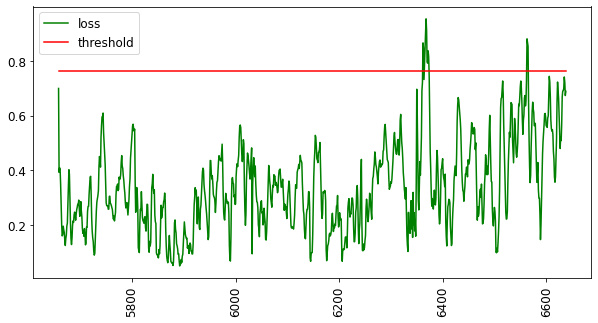

In [39]:
plt.figure(figsize = (10,5))
plt.plot(test_score_df.index, test_score_df['loss'], color = 'green', label='loss')
plt.plot(test_score_df.index, test_score_df['threshold'], color = 'r', label='threshold')
plt.xticks(rotation=90)
plt.legend();

In [40]:
anomalies = test_score_df[test_score_df['anomaly'] == True]

x = pd.DataFrame(anomalies.Close)
x = pd.DataFrame(scaler.inverse_transform(x))

x.index = anomalies.index
x.rename(columns = {0: 'inverse_price'}, inplace = True)

anomalies = anomalies.join(x, how = 'left')
print(anomalies.shape)
anomalies

(14, 6)


,Date,Close,loss,threshold,anomaly,inverse_price
6362,2020-04-09,3.212648,0.866659,0.761987,True,141.229996
6363,2020-04-13,3.153943,0.849118,0.761987,True,139.770004
6365,2020-04-15,3.471192,0.792864,0.761987,True,147.660004
6366,2020-04-16,3.552011,0.860412,0.761987,True,149.669998
6367,2020-04-17,3.646503,0.902793,0.761987,True,152.020004
6368,2020-04-20,3.632429,0.954642,0.761987,True,151.669998
6369,2020-04-21,3.552413,0.911734,0.761987,True,149.679993
6370,2020-04-22,3.685506,0.797243,0.761987,True,152.990005
6371,2020-04-23,3.786832,0.792463,0.761987,True,155.509995
6372,2020-04-24,3.760696,0.837511,0.761987,True,154.860001


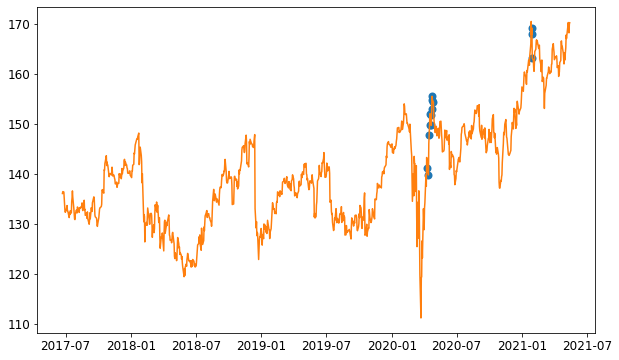

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(test_score_df['Date'], scaler.inverse_transform(test_score_df['Close']), color='tab:orange', label='Windspeed')
ax.scatter(anomalies['Date'], scaler.inverse_transform(anomalies['Close']), marker='o' , linewidths=2)


